<a href="https://colab.research.google.com/github/tanakakao/test/blob/main/efficientnet_v1_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Add, Multiply, ReLU, Dropout
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import math
import cv2

In [2]:
def hard_sigmoid(x):
    return ReLU(6.)(x + 3.) * (1. / 6.)

def hard_swish(x):
    return Multiply()([Activation(hard_sigmoid)(x), x])

class SE_Block(Model):
    def __init__(self, in_channels, r=0.25):
        super().__init__()
        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(int(in_channels*r))
        self.relu = Activation(hard_sigmoid)
        self.fc2 = Dense(in_channels, activation='sigmoid')
    
    def call(self, x):
        out = self.pool(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = Multiply()([x, out])
        return out

In [3]:
class MobileConv(Model):
    def __init__(self, in_channels, out_channels, kernel, t, s, r=0.25):
        super().__init__()
        exp_size = int(t*in_channels)
        
        self.conv1 = Conv2D(filters = exp_size, kernel_size = (1,1), padding = 'same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(swish)
    
        self.conv2 = DepthwiseConv2D(kernel_size = kernel, strides=s, padding = 'same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(swish)

        self.conv3 = Conv2D(filters = out_channels, kernel_size = (1,1), padding = 'same')
        self.bn3 = BatchNormalization()
        self.relu3 = Activation(swish)
        
        self.se = SE_Block(in_channels=out_channels, r=r)
        
        self.drop = Dropout(rate=0.8,noise_shape=(None, 1, 1, 1))
        self.add = Add()
    
    def call(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        
        out = self.se(out)
        
        if K.int_shape(out) == K.int_shape(x):
            out = self.drop(out)
            out = self.add([out, x])
        
        return out

In [4]:
class EfficientNet(Model):
    def __init__(self, d,w,p=0.2):
        super().__init__()    
        self.conv1 = Conv2D(filters = 32, kernel_size = 3, strides=2, padding = 'same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(swish)

        self.mbconv1 = self._mobile_conv(in_channels=32,             out_channels=np.ceil(16*w),  kernel=3, L=np.ceil(1*d), t=1, down_sample=False)
        self.mbconv2 = self._mobile_conv(in_channels=np.ceil(16*w),  out_channels=np.ceil(24*w),  kernel=3, L=np.ceil(2*d), t=6, down_sample=True)
        self.mbconv3 = self._mobile_conv(in_channels=np.ceil(24*w),  out_channels=np.ceil(40*w),  kernel=5, L=np.ceil(2*d), t=6, down_sample=True)
        self.mbconv4 = self._mobile_conv(in_channels=np.ceil(40*w),  out_channels=np.ceil(80*w),  kernel=3, L=np.ceil(3*d), t=6, down_sample=True)
        self.mbconv5 = self._mobile_conv(in_channels=np.ceil(80*w),  out_channels=np.ceil(112*w), kernel=5, L=np.ceil(3*d), t=6, down_sample=False)
        self.mbconv6 = self._mobile_conv(in_channels=np.ceil(112*w), out_channels=np.ceil(192*w), kernel=5, L=np.ceil(4*d), t=6, down_sample=True)
        self.mbconv7 = self._mobile_conv(in_channels=np.ceil(192*w), out_channels=np.ceil(320*w), kernel=5, L=np.ceil(1*d), t=6, down_sample=False)
        
        self.conv2 = Conv2D(filters = 1280, kernel_size = 1, strides=1, padding = 'same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(swish)
        
        self.pool = GlobalAveragePooling2D()
        self.drop1 = Dropout(p)
        self.fc1 = Dense(1280)
        self.relu3 = Activation(swish)
        self.drop2 = Dropout(p)
        self.fc2 = Dense(10, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.mbconv1(x)
        x = self.mbconv2(x)
        x = self.mbconv3(x)
        x = self.mbconv4(x)
        x = self.mbconv5(x)
        x = self.mbconv6(x)
        x = self.mbconv7(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        x = self.drop1(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.drop2(x)
        x = self.fc2(x)
        
        return x
    
    def _mobile_conv(self, in_channels, out_channels, kernel, L, t, down_sample=True):
        mb_layers = []
        for i in range(int(L)):
            s = 1
            if (i==0):
                in_channels=in_channels
                if down_sample:
                    s = 2
            else:
                in_channels = out_channels
                
            mb_layers.append(MobileConv(in_channels=in_channels, out_channels=out_channels, kernel=kernel, t=t, s=s))

        return Sequential(mb_layers)

In [5]:
R={'B0':224, 'B1':240, 'B2':260, 'B3':300, 'B4':380, 'B5':456, 'B6':528, 'B7':600}
D={'B0':1, 'B1':1.1, 'B2':1.2, 'B3':1.4, 'B4':1.8, 'B5':2.2, 'B6':2.6, 'B7':3.1} # L
W={'B0':1, 'B1':1, 'B2':1.1, 'B3':1.2, 'B4':1.4, 'B5':1.6, 'B6':1.8, 'B7':2} #C
P={'B0':0.2, 'B1':0.2, 'B2':0.3, 'B3':0.3, 'B4':0.4, 'B5':0.4, 'B6':0.5, 'B7':0.5}

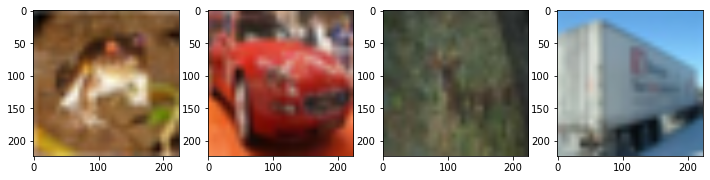

In [6]:
model_type='B0'
h=R[model_type]

# データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# バッチサイズ、クラス数、エポック数の設定
batch_size=64
num_classes=10

# データリサイズ
img_rows=h
img_cols=h

x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train[::5,:,:,:]])
x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test[::5,:,:,:]])

# データ正規化
x_train=x_train.astype('float32')
x_train/=255
x_test=x_test.astype('float32')
x_test/=255

# one-hotベクトル化
y_train = y_train[::5]
y_test = y_test[::5]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(x_train[i]) for i in range(4)];

In [7]:
from keras.callbacks import EarlyStopping

# EaelyStoppingの設定
early_stopping =  EarlyStopping(
                            monitor='val_loss',
                            min_delta=0,
                            patience=20,
)

epochs = 200
initial_lrate = 0.000001

def decay(epoch, steps=200):
    initial_lrate = 0.000001
    drop = 0.97
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(lr=initial_lrate)

lr_sc = LearningRateScheduler(decay, verbose=1)

model = EfficientNet(d=D[model_type], w=W[model_type], p=P[model_type])
model.compile(loss=['categorical_crossentropy'], optimizer="rmsprop", metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
157/157 [==============================] - 95s 451ms/step - loss: 2.4498 - accuracy: 0.1036 - val_loss: 2.3130 - val_accuracy: 0.0985
Epoch 2/200
157/157 [==============================] - 68s 430ms/step - loss: 2.3210 - accuracy: 0.1007 - val_loss: 2.3321 - val_accuracy: 0.1025
Epoch 3/200
157/157 [==============================] - 68s 431ms/step - loss: 2.3144 - accuracy: 0.1019 - val_loss: 2.3052 - val_accuracy: 0.1000
Epoch 4/200
157/157 [==============================] - 68s 430ms/step - loss: 2.3109 - accuracy: 0.1010 - val_loss: 2.3057 - val_accuracy: 0.1060
Epoch 5/200
157/157 [==============================] - 68s 431ms/step - loss: 2.2013 - accuracy: 0.1553 - val_loss: 2.1377 - val_accuracy: 0.1825
Epoch 6/200
157/157 [==============================] - 68s 431ms/step - loss: 1.9992 - accuracy: 0.2124 - val_loss: 2.0188 - val_accuracy: 0.2075
Epoch 7/200
157/157 [==============================] - 68s 430ms/step - loss: 1.8443 - accuracy: 0.2786 - val_loss: 1.9595 -